# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import LongType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import BooleanType



from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.window import Window

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt



import re
import seaborn as sns

from pyspark.sql.functions import explode, lit, min, max, split, isnull

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import DenseVector, SparseVector

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
userlog = spark.read.json("mini_sparkify_event_data.json")

### Explore basic information

In [4]:
print('&&&&&&&')
print('detailed data demo')
print(userlog.head(n=3))   ## or use take
print('&&&&&&&')
print('type')
print(userlog.describe())
print('&&&&&&&')
print('detailed data demo 2')
print(userlog.show(n=3))
print('&&&&&&&')
print('Schema')
print(userlog.printSchema())

&&&&&&&
detailed data demo
[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'), Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273,

### Check the Missing Values

In [5]:
print(userlog.count())

286500


In [6]:
userlog_valid = userlog.dropna(how = "any", subset = ["userId", "sessionId"])
userlog_valid.count()

286500

#### 1. UserId

In [7]:
userlog.select("userId").dropDuplicates().sort("userId").show(n=5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



We notice that the userID has the empty string which might be the users who have not signed up or who are signed out and are about to log in.

In [8]:
userlog_valid = userlog_valid.filter(userlog_valid["userId"] != "")
userlog_valid.count()

278154

#### 2. Artist

In [9]:
userlog_valid.filter(col("artist").isNull()).show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [10]:
### it seems null artist is bonded with null length and null song, check it
userlog.filter((col("artist").isNull()) & (col("length").isNotNull())).show(n=3)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [11]:
userlog.filter((col("artist").isNull()) & (col("song").isNotNull())).show(n=3)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



Artist, length, song share the same null value in single document. 
### But we cannot discard them.

The definition below is bonded with null values of three cols above.

In [12]:
userlog_valid.filter("page = 'Cancellation Confirmation'").show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

#### 3. Auth, firstName, gender 

In [13]:
userlog_valid.filter(col("auth").isNull() | col("firstName").isNull() | col("gender").isNull()).show(n=5)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



The Columns 'auth', 'firstName', 'gender' are fine with null value.

#### 4. itemInSession, lastName, level

In [14]:
userlog_valid.filter(col("itemInSession").isNull() | col("lastName").isNull() | col("level").isNull()).show(n=5)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



The Columns 'itemInSession', 'lastName', 'level' are fine with null value.

#### 5. location, method, page

In [15]:
userlog_valid.filter(col("location").isNull() | col("method").isNull() | col("page").isNull()).show(n=5)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



The Columns 'location', 'method', 'page' are fine with null value.

#### 6. registration, sessionId, status

In [16]:
userlog_valid.filter(col("registration").isNull() | col("sessionId").isNull() | col("status").isNull()).show(n=5)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



The Columns 'registration', 'sessionId', 'status' are fine with null value.

#### 7. ts, userAgent

In [17]:
userlog_valid.filter(col("ts").isNull() | col("userAgent").isNull()).show(n=5)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



The Columns 'ts', 'userAgent' are fine with null value.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.



#### Find the users who downgrade their accounts

In [18]:
## first check all the categories of page
userlog_valid.select("page").dropDuplicates().sort("page").show(n=30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [19]:
userlog_valid.filter("page = 'Cancellation Confirmation'").show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [20]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
userlog_valid = userlog_valid.withColumn("time", get_time(userlog_valid.ts))

In [21]:
userlog_valid.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', time='2018-10-01 00:03:00'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastN

In [22]:
### check userId 125
userlog_valid.select(["userId", "page", "time", "level", "song", "sessionId"]).where(userlog_valid.userId == "125").sort("time").show(30)

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|               time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|2018-10-12 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|2018-10-12 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|2018-10-12 04:

#### Add churn column to userlog_valid

In [22]:
#userlog_valid=usrlg2
#userlog_valid.show(n=5)

In [101]:
#flag_downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
# this is only for one document not for all documents of one user

In [23]:
churnuser = userlog_valid.filter(userlog_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates()

In [24]:
churnuserlist = [(row['userId']) for row in churnuser.collect()]

In [25]:
userlog_valid = userlog_valid.withColumn("churn", userlog_valid.userId.isin(churnuserlist))

In [26]:
#userlog_valid.filter("churn = 'True'").show(52)
userlog_valid.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|               time|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|false|
|Five Iron Frenzy|Logged In|    Micah|     M

In [27]:
userlog_valid.dropDuplicates(["userId"]).groupby(["churn"]).count().sort("churn").show()

+-----+-----+
|churn|count|
+-----+-----+
|false|  173|
| true|   52|
+-----+-----+



In [29]:
userlog_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: boolean (nullable = true)



In [45]:
userlog_valid.write.save('validdata1', format="csv", header=True)

In [46]:
userlog_valid = spark.read.csv('validdata1', header=True)
userlog_valid.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, time: string, churn: string]

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [35]:
#userlog_valid=userlog_valid.drop('_c0')

In [47]:
### Index of our data exploration
userlog_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: string (nullable = true)



In [48]:
### Modify the type
userlog_valid=userlog_valid.withColumn('itemInSession',userlog_valid['itemInSession'].cast(LongType()))
userlog_valid=userlog_valid.withColumn('length',userlog_valid['length'].cast(DoubleType()))
userlog_valid=userlog_valid.withColumn('registration',userlog_valid['registration'].cast(LongType()))
userlog_valid=userlog_valid.withColumn('sessionId',userlog_valid['sessionId'].cast(LongType()))
userlog_valid=userlog_valid.withColumn('status',userlog_valid['status'].cast(LongType()))
userlog_valid=userlog_valid.withColumn('ts',userlog_valid['ts'].cast(LongType()))
userlog_valid=userlog_valid.withColumn('churn',userlog_valid['churn'].cast(BooleanType()))

In [49]:
userlog_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: boolean (nullable = true)



#### 1. artist vs churn

In [50]:
userlog_valid.select("artist").distinct().show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [51]:
# total number of artists
df_artist=userlog_valid.select("artist").distinct().toPandas()
print(df_artist.head())
print(df_artist.count())

             artist
0    The Black Keys
1       Silverstein
2         Kate Nash
3      Yann Tiersen
4  Jane's Addiction
artist    17655
dtype: int64


In [52]:
df_artist_count = userlog_valid.filter(userlog_valid.page=="NextSong").select("userId", "artist", "churn").dropDuplicates().groupby("userId","churn").count().toPandas()

In [53]:
df_artist_count.head(10)

,userId,churn,count
0,19,False,197
1,200007,False,64
2,100005,True,149
3,300007,True,107
4,50,False,423
5,200002,False,339
6,30,False,1018
7,8,False,230
8,100012,True,397
9,100011,True,11


In [54]:
#### number of artists by each churn user

artist1=df_artist_count['count'][df_artist_count.churn==True]

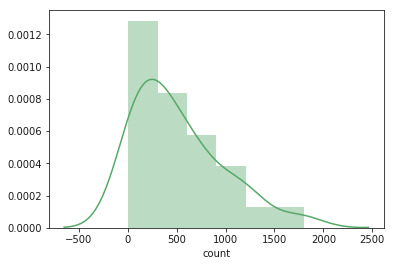

In [55]:
sns.set_color_codes()
ax=sns.distplot(artist1, color='g')

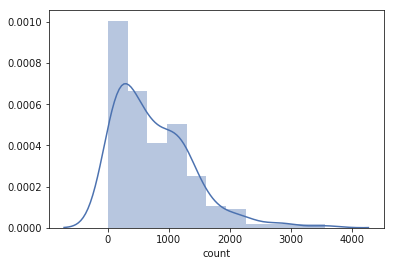

In [56]:
### no churn
artist2=df_artist_count['count'][df_artist_count.churn==False]
ax=sns.distplot(artist2, color='b')

#### 2. auth vs churn

In [57]:
userlog_valid.select("auth").distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [58]:
userlog_valid.dropDuplicates(["userId", "auth"]).groupby(["auth","churn"]).count().sort("churn").show()

+---------+-----+-----+
|     auth|churn|count|
+---------+-----+-----+
|Logged In|false|  173|
|Cancelled| true|   52|
|Logged In| true|   52|
+---------+-----+-----+



In [59]:
userlog_valid.dropDuplicates(["userId"]).groupby(["churn"]).count().sort("churn").show()

+-----+-----+
|churn|count|
+-----+-----+
|false|  173|
| true|   52|
+-----+-----+



In [60]:
### user with true churn has the final auth "Cancelled"
userlog_valid.select(["userId", "auth", 'churn']).where(userlog_valid.userId == "125").sort("time").show(100)

+------+---------+-----+
|userId|     auth|churn|
+------+---------+-----+
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Logged In| true|
|   125|Cancelled| true|
+------+---------+-----+



In [61]:
### user with true churn does not have the final auth "Cancelled"
userlog_valid.select(["userId", "auth", 'churn']).where(userlog_valid.userId == "30").sort("time").show(100)

+------+---------+-----+
|userId|     auth|churn|
+------+---------+-----+
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|
|    30|Logged In|false|


The user with auth 'Cancelled' is same with 'churn'. It might cause data leakage when we use 'auth' as one feature for our modeling

#### 3. firstname vs churn

In [62]:
df_fname=userlog_valid.select("firstname").distinct().toPandas()
print(df_fname.head())
print(df_fname.count())

  firstname
0    Maddox
1    Karter
2     Lucas
3     Grace
4  Antonina
firstname    189
dtype: int64


#### 4. gender vs churn

In [63]:
userlog_valid.dropDuplicates(["userId", "gender"]).groupby(["gender","churn"]).count().sort("churn").show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|false|   84|
|     M|false|   89|
|     M| true|   32|
|     F| true|   20|
+------+-----+-----+



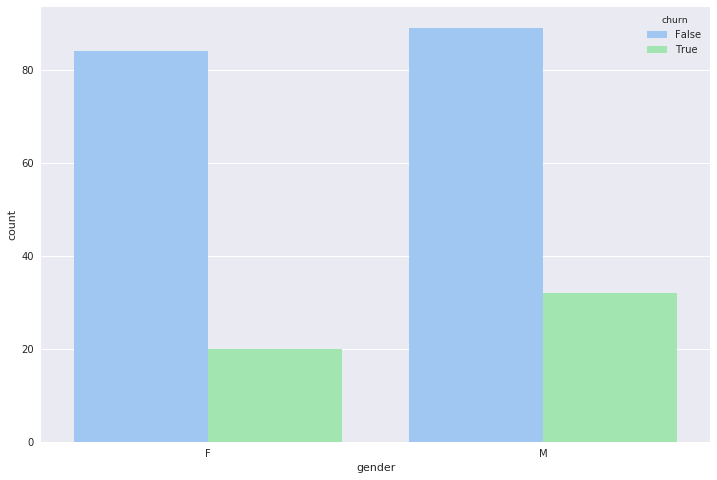

In [64]:
df_genderchurn = userlog_valid.dropDuplicates(["userId", "gender"]).groupby(["gender","churn"]).count().sort("churn").toPandas()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_palette("pastel")
ax=sns.barplot(x='gender', y='count', hue='churn', data=df_genderchurn)

#### 5. itemInSession vs churn

In [65]:
userlog_valid.select("itemInSession").distinct().show()

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
|         1224|
|         1258|
|         1277|
|          222|
|          270|
|          293|
|          730|
|          938|
|         1127|
|         1145|
+-------------+
only showing top 20 rows



In [66]:
# number of iteminSession
df_item=userlog_valid.select("itemInSession").distinct().toPandas()
print(df_item.head())
print(df_item.count())

   itemInSession
0             26
1             29
2            474
3            964
4             65
itemInSession    1311
dtype: int64


#### 6. lastname vs churn

In [67]:
df_lname=userlog_valid.select("lastname").distinct().toPandas()
print(df_lname.head())
print(df_lname.count())

   lastname
0  Harrison
1  Thornton
2      Pena
3     Jones
4    Santos
lastname    173
dtype: int64


#### 7. length vs churn

length    8470
dtype: int64
44864
36394


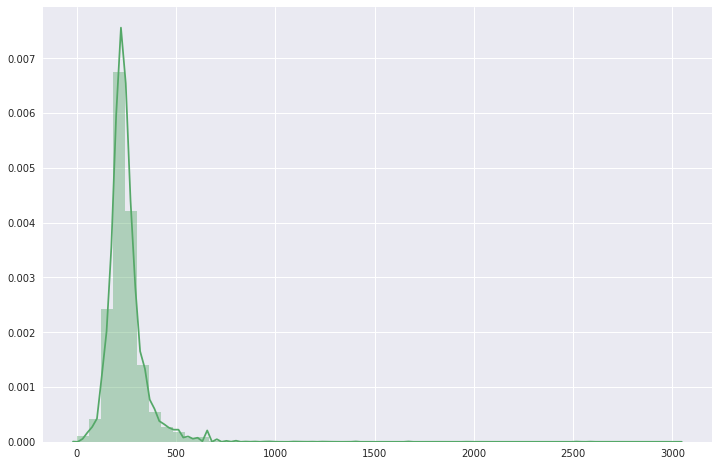

In [68]:
# churn
df_len1=userlog_valid.filter(userlog_valid.churn==1).select('length').toPandas()
print(df_len1.isnull().sum())
print(len(df_len1))
df_len1nonull=df_len1.dropna()
print(len(df_len1nonull))
ax=sns.distplot(df_len1nonull, color='g')

length    41576
dtype: int64
233290
191714


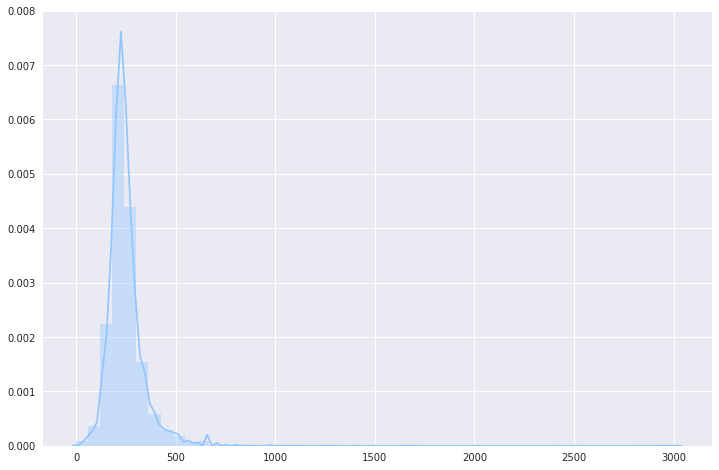

In [69]:
# no churn
df_len0=userlog_valid.filter(userlog_valid.churn==0).select('length').toPandas()
print(df_len0.isnull().sum())
print(len(df_len0))
df_len0nonull=df_len0.dropna()
print(len(df_len0nonull))
ax=sns.distplot(df_len0nonull)

In [70]:
### avg length for each user
avglength = userlog_valid.select("userId", "length", "churn").groupby("userId","churn").avg().toPandas()

In [71]:
avglength.head()

,userId,churn,avg(length)
0,19,False,252.226546
1,100005,True,240.500792
2,200007,False,242.151836
3,300007,True,252.510905
4,50,False,244.038321


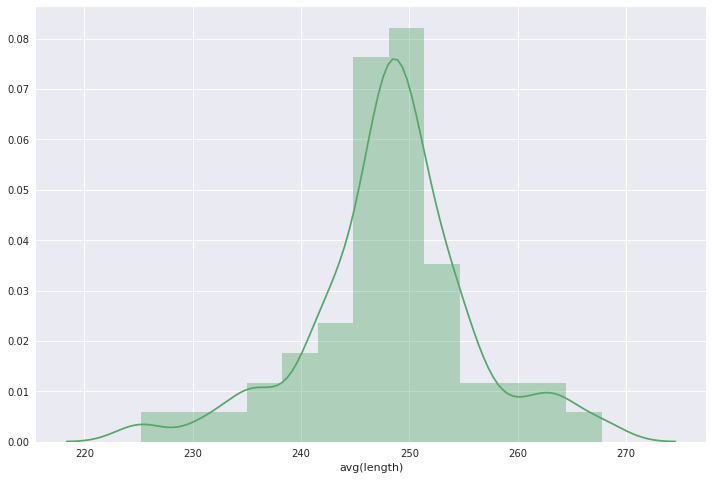

In [72]:
avglen1=avglength['avg(length)'][avglength.churn==True]
ax=sns.distplot(avglen1, color='g')

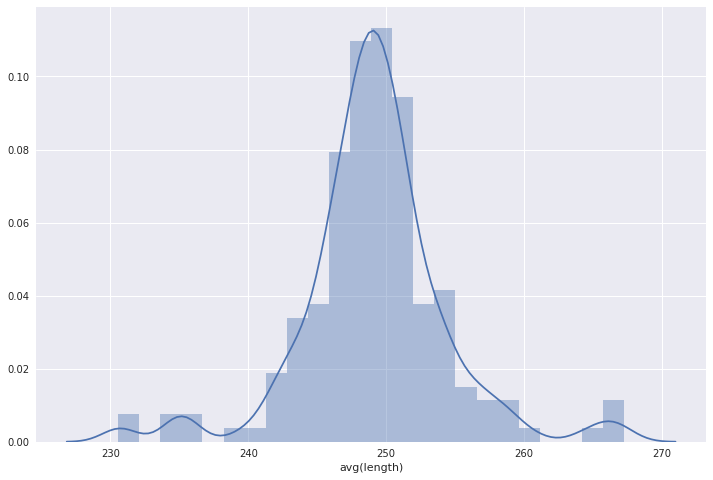

In [73]:
avglen2=avglength['avg(length)'][avglength.churn==False]
ax=sns.distplot(avglen2, color='b')

#### 8. level vs churn

In [74]:
userlog_valid.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [75]:
userlog_valid.dropDuplicates(["userId", "level"]).groupby(["level","churn"]).count().sort("churn").show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|false|  129|
| free|false|  149|
| paid| true|   36|
| free| true|   46|
+-----+-----+-----+



In [76]:
userlog_valid.select("userId", "level", "churn").show(n=5)

+------+-----+-----+
|userId|level|churn|
+------+-----+-----+
|    30| paid|false|
|     9| free|false|
|    30| paid|false|
|     9| free|false|
|    30| paid|false|
+------+-----+-----+
only showing top 5 rows



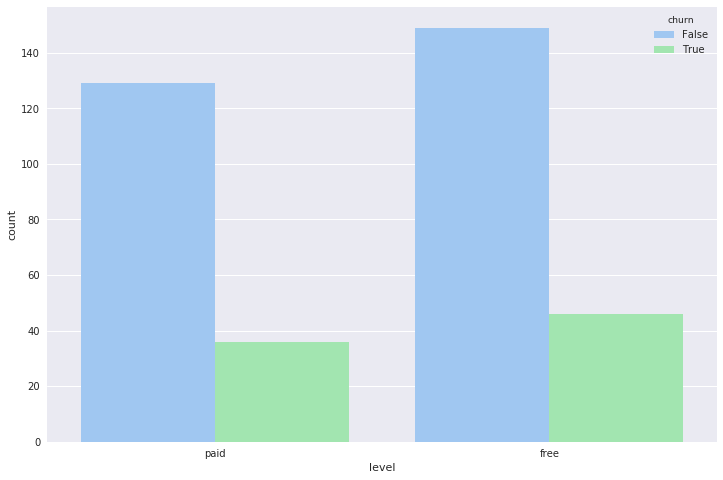

In [77]:
df_levelchurn = userlog_valid.dropDuplicates(["userId", "level"]).groupby(["level","churn"]).count().sort("churn").toPandas()

ax=sns.barplot(x='level', y='count', hue='churn', data=df_levelchurn)

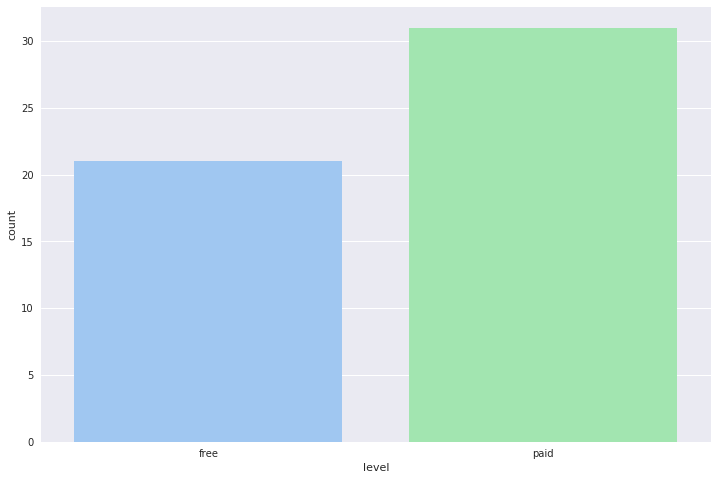

In [78]:
### need to check?
df_pd = userlog_valid.filter(userlog_valid.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

#### 9. location vs churn

In [79]:
userlog_valid.select("location").distinct().show(n=5)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
+--------------------+
only showing top 5 rows



In [80]:
df_loc=userlog_valid.select("location").distinct().toPandas()
print(df_loc.head())
print(df_loc.count())

                                 location
0                         Gainesville, FL
1             Atlantic City-Hammonton, NJ
2  Deltona-Daytona Beach-Ormond Beach, FL
3                  San Diego-Carlsbad, CA
4                    Cleveland-Elyria, OH
location    114
dtype: int64


#### 10. method vs churn

In [81]:
userlog_valid.select("method").distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [82]:
userlog_valid.dropDuplicates(["userId", "method"]).groupby(["method","churn"]).count().sort("churn").show()

+------+-----+-----+
|method|churn|count|
+------+-----+-----+
|   PUT|false|  173|
|   GET|false|  172|
|   GET| true|   52|
|   PUT| true|   52|
+------+-----+-----+



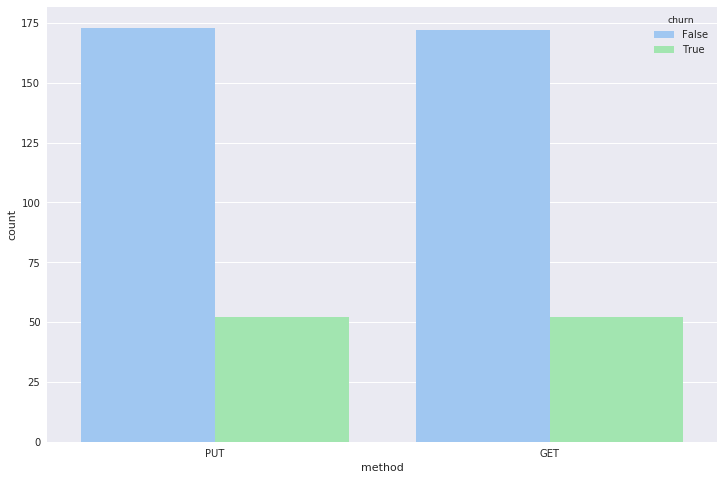

In [83]:
df_methodchurn = userlog_valid.dropDuplicates(["userId", "method"]).groupby(["method","churn"]).count().sort("churn").toPandas()

ax=sns.barplot(x='method', y='count', hue='churn', data=df_methodchurn)

#### 11. page vs churn

In [84]:
userlog_valid.select("page").distinct().show(n=30)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [85]:
churn_count = userlog_valid.filter(userlog_valid.churn==1).count()
no_churn_count = userlog_valid.filter(userlog_valid.churn==0).count()

df_temp1 = userlog_valid.filter(userlog_valid.churn==1).filter(userlog_valid.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = userlog_valid.filter(userlog_valid.churn==0).filter(userlog_valid.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

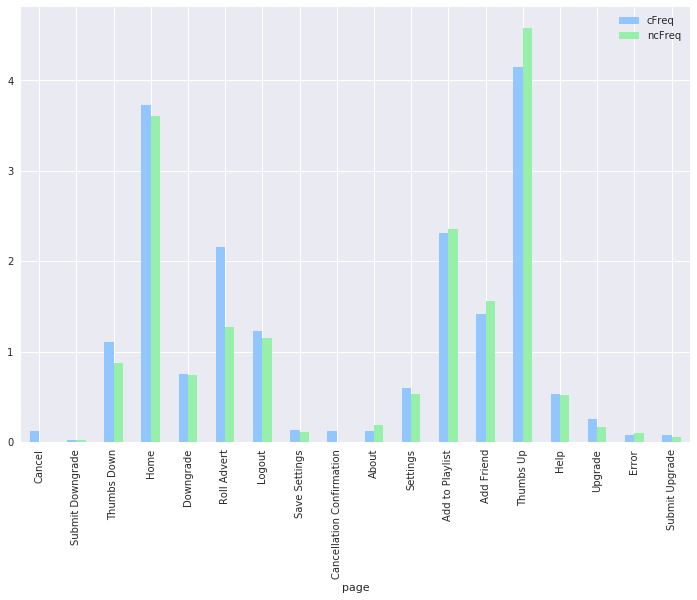

In [86]:
df_page = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
#sns.set_palette("Muted")
df_page.plot.bar("page")

#### fresh up

In [87]:
userlog_valid.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|               time|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|false|
|Five Iron Frenzy|Logged In|    Micah|     M

#### 12. regsitration vs churn

registration    0
dtype: int64
44864
44864


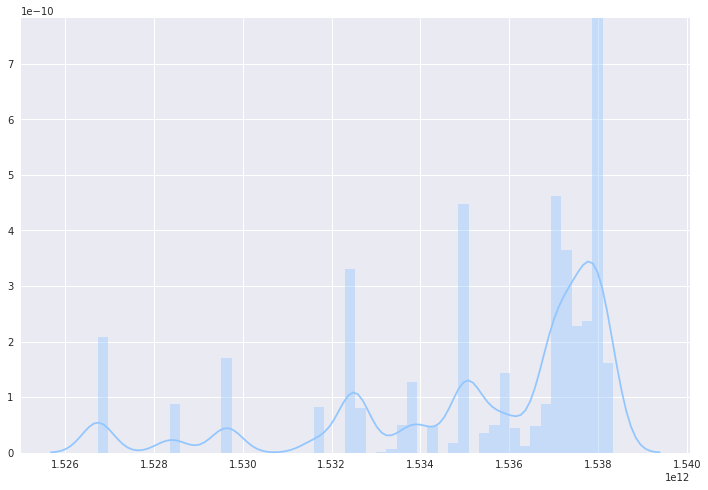

In [88]:
# churn
df_reg1=userlog_valid.filter(userlog_valid.churn==1).select('registration').toPandas()
print(df_reg1.isnull().sum())
print(len(df_reg1))
df_reg1nonull=df_reg1.dropna()
print(len(df_reg1nonull))
ax=sns.distplot(df_reg1nonull)

registration    0
dtype: int64
233290
233290


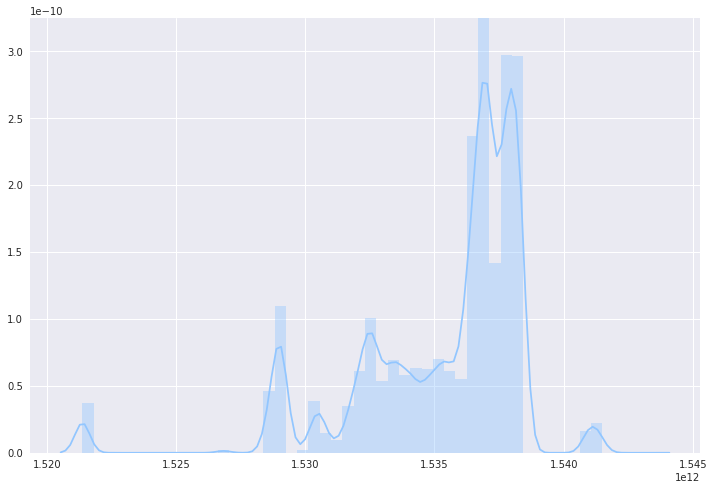

In [89]:
# not churn
df_reg0=userlog_valid.filter(userlog_valid.churn==0).select('registration').toPandas()
print(df_reg0.isnull().sum())
print(len(df_reg0))
df_reg0nonull=df_reg0.dropna()
print(len(df_reg0nonull))
ax=sns.distplot(df_reg0nonull)

#### 13. sessionId vs churn

sessionId    0
dtype: int64
44864
44864


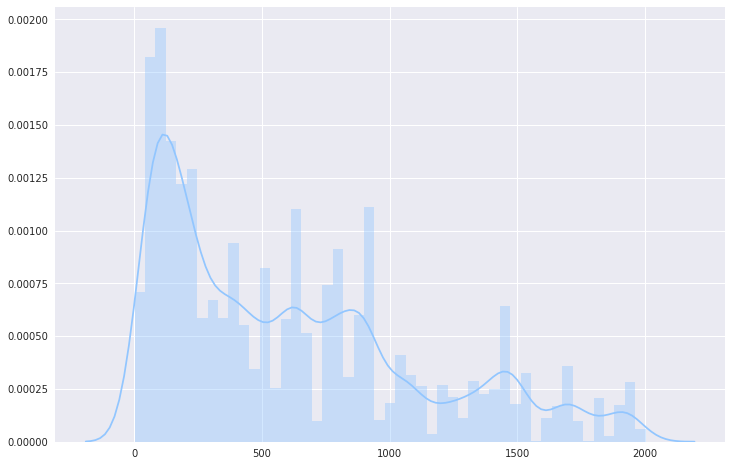

In [90]:
# churn
df_ses1=userlog_valid.filter(userlog_valid.churn==1).select('sessionId').toPandas()
print(df_ses1.isnull().sum())
print(len(df_ses1))
df_ses1nonull=df_ses1.dropna()
print(len(df_ses1nonull))
ax=sns.distplot(df_ses1nonull)

sessionId    0
dtype: int64
233290
233290


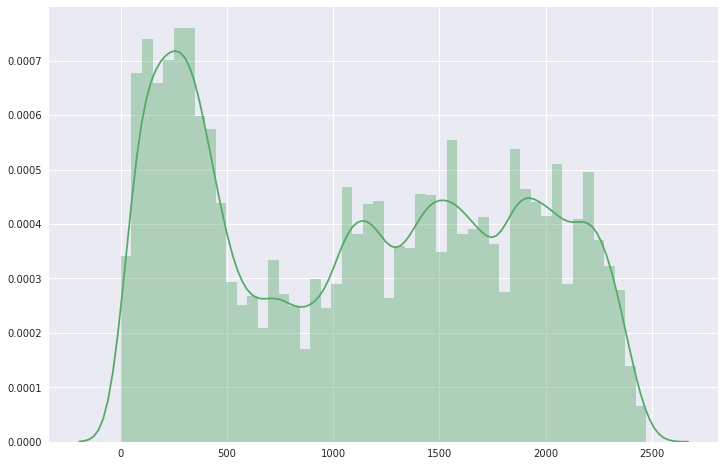

In [93]:
# no churn
df_ses0=userlog_valid.filter(userlog_valid.churn==0).select('sessionId').toPandas()
print(df_ses0.isnull().sum())
print(len(df_ses0))
df_ses0nonull=df_ses0.dropna()
print(len(df_ses0nonull))
ax=sns.distplot(df_ses0nonull, color='g')

In [94]:
### for each user
df_session_count = userlog_valid.select("userId", "sessionId", "churn").dropDuplicates().groupby("userId","churn").count().toPandas()

In [95]:
df_session_count.head()

,userId,churn,count
0,19,False,1
1,200007,False,3
2,100005,True,5
3,300007,True,1
4,50,False,8


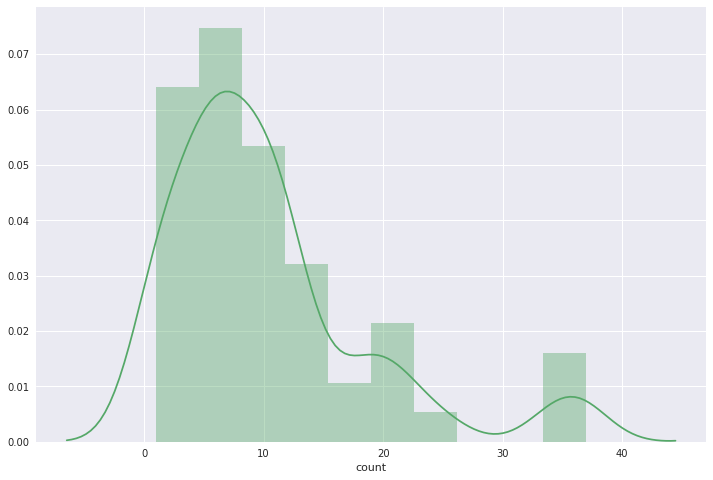

In [96]:
### for churn user
session1=df_session_count['count'][df_session_count.churn==True]
ax=sns.distplot(session1, color='g')

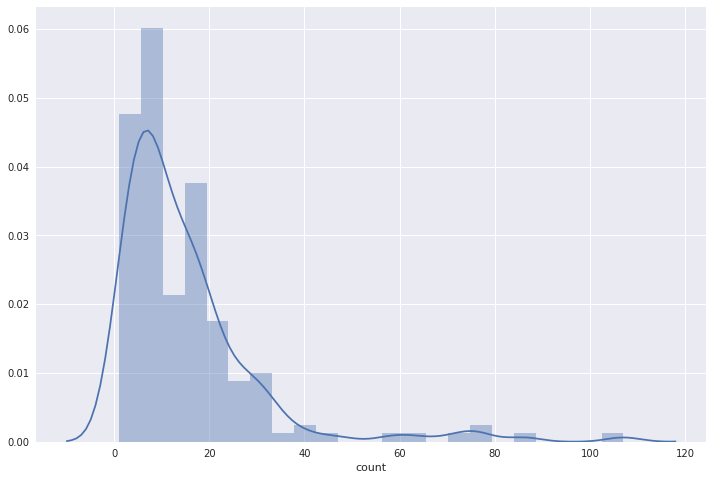

In [97]:
### for no churn user
session2=df_session_count['count'][df_session_count.churn==False]
ax=sns.distplot(session2, color='b')

#### 14. song vs churn

In [98]:
df_song=userlog_valid.select("song").distinct().toPandas()
print(df_song.head())
print(df_song.count())

                                   song
0  Never Gonna Be Alone (Album Version)
1                           TULENLIEKKI
2                        Underwaterboys
3         Saor (Free)/News From Nowhere
4                                 New E
song    58475
dtype: int64


In [99]:
### for each user
df_song_count = userlog_valid.select("userId", "song", "churn").dropDuplicates().groupby("userId","churn").count().toPandas()

In [100]:
df_song_count.head()

,userId,churn,count
0,19,False,210
1,100005,True,154
2,200007,False,66
3,300007,True,112
4,50,False,477


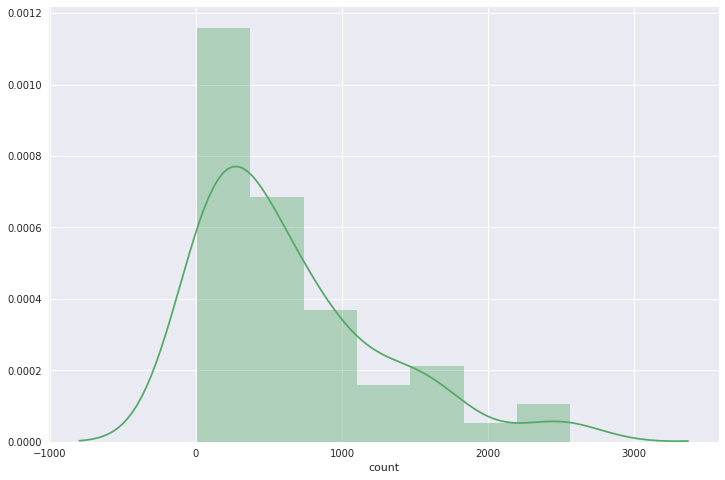

In [101]:
### for churn user
song1=df_song_count['count'][df_song_count.churn==True]
ax=sns.distplot(song1, color='g')

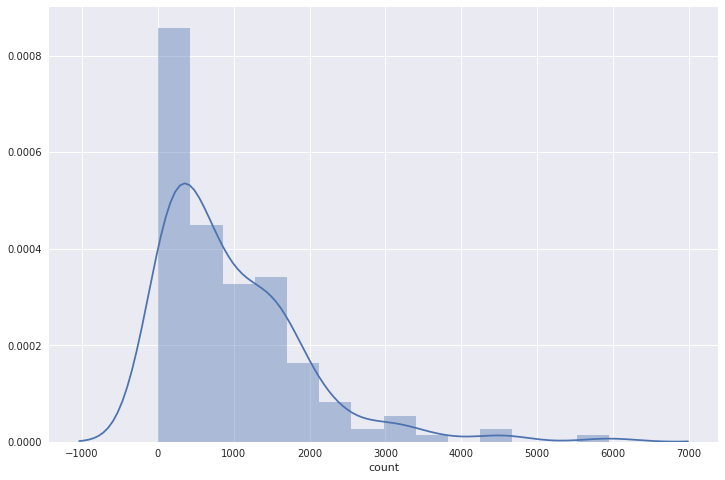

In [102]:
### for no churn user
song2=df_song_count['count'][df_song_count.churn==False]
ax=sns.distplot(song2, color='b')

#### 15. status vs churn

In [103]:
userlog_valid.select("status").distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [104]:
userlog_valid.dropDuplicates(["userId", "status"]).groupby(["status","churn"]).count().sort("churn").show()

+------+-----+-----+
|status|churn|count|
+------+-----+-----+
|   404|false|   95|
|   200|false|  173|
|   307|false|  171|
|   307| true|   52|
|   200| true|   52|
|   404| true|   22|
+------+-----+-----+



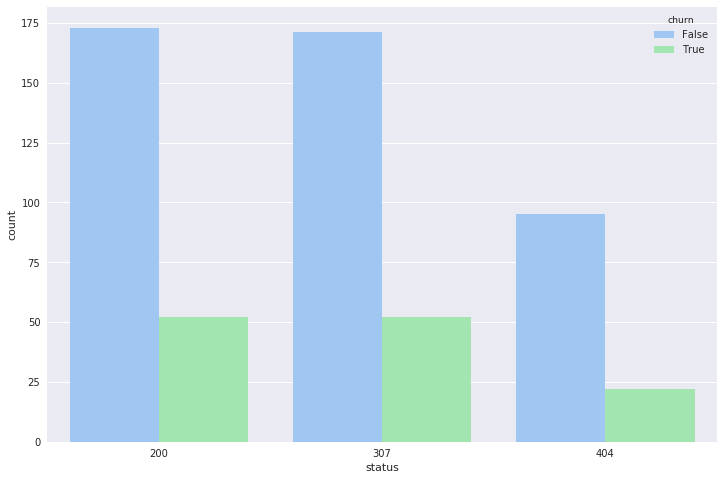

In [105]:
df_statuschurn = userlog_valid.dropDuplicates(["userId", "status"]).groupby(["status","churn"]).count().sort("churn").toPandas()

ax=sns.barplot(x='status', y='count', hue='churn', data=df_statuschurn)

#### 16. ts vs churn

In [106]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
userlog_valid = userlog_valid.withColumn("hour", get_hour(userlog_valid.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
userlog_valid = userlog_valid.withColumn("weekday", get_weekday(userlog_valid.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
userlog_valid = userlog_valid.withColumn("day", get_day(userlog_valid.ts))

In [107]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = userlog_valid.filter(userlog_valid.page == "NextSong").groupby("churn", time).count().orderBy(userlog_valid[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    sns.set_palette("pastel")
    ax=sns.barplot(x=time, y='count', hue='churn', data=df_pd)

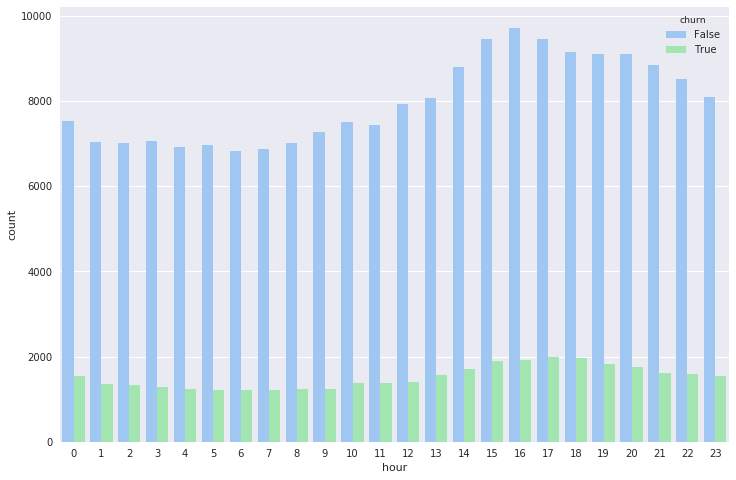

In [108]:
plot_cnt_by_churn("hour")

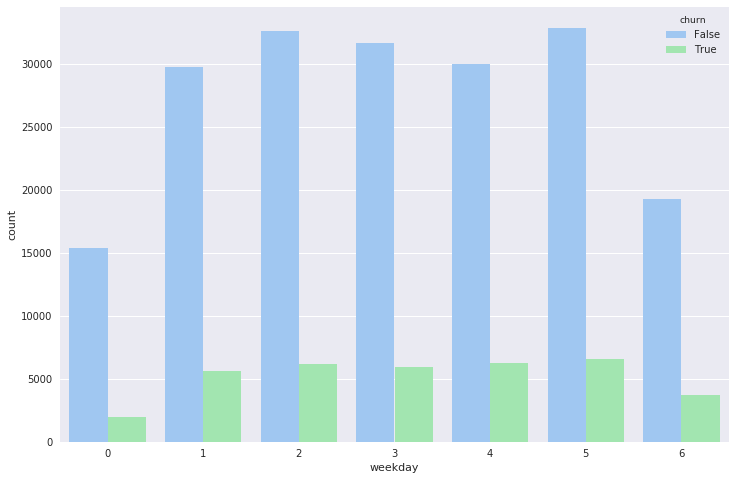

In [109]:
plot_cnt_by_churn("weekday")

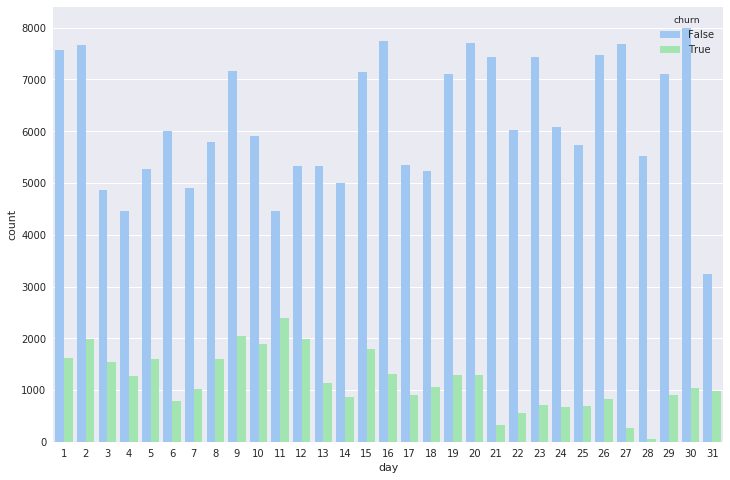

In [110]:
plot_cnt_by_churn("day")

#### 17. userAgent vs churn

In [111]:
userlog_valid.select("userAgent").distinct().show(n=3)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
+--------------------+
only showing top 3 rows



In [112]:
df_uA=userlog_valid.select("userAgent").distinct().toPandas()
print(df_uA.head())
print(df_uA.count())

                                           userAgent
0  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...
1  "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....
2  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...
3  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...
4  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...
userAgent    56
dtype: int64


#### 18. userId vc churn

In [113]:
df_user=userlog_valid.select("userId").distinct().toPandas()
print(df_user.head())
print(df_user.count())

   userId
0  100010
1  200002
2     125
3      51
4     124
userId    225
dtype: int64


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [114]:
userlog_valid.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+----+-------+---+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|               time|churn|hour|weekday|day|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+----+-------+---+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|

### Ex 1 Artist -> Feature 1: Number of artists heard by the user

In [115]:
artist_count = userlog_valid.filter(userlog_valid.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
artist_count = artist_count.withColumnRenamed("count", "aritstCount")

In [116]:
artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



### Ex 2: Auth of each user

As we have explored before, there might be the data leakage for this column. So we do not use it.

### Ex 3: First name

We do not consider the first name as the input of our model.

### Ex 4 Gender -> Feature 2: Gender of each user

In [117]:
user_gender = userlog_valid.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

In [118]:
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



### Ex 5: ItemInSession

We need more explanation for this column.

### Ex 6: Last name

Same as the first name, we do not use it.

### Ex 7 Length -> Feature 3:  Length, average length for each user

In [119]:
avg_length = userlog_valid.select("userId", "length").groupby("userId").avg()
avg_length = avg_length.withColumnRenamed("avg(length)", "avglength")

In [120]:
avg_length.show(5)

+------+------------------+
|userId|         avglength|
+------+------------------+
|100010|  243.421444909091|
|200002|242.91699209302305|
|   125|261.13913750000006|
|    51|247.88055082899118|
|   124|248.17653659965674|
+------+------------------+
only showing top 5 rows



### Ex 8 Level -> Feature 4: The most recent level status

In [121]:
user_paid = userlog_valid.groupby("userId", "level").agg(max(userlog_valid.ts).alias("finalTime")).sort("userId")
recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
recent_level = recent_level_time.join(user_paid, [user_paid.userId == recent_level_time.userId, recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
recent_level = recent_level.replace(["free", "paid"], ["0", "1"], "level")
recent_level = recent_level.select("userId", recent_level.level.cast("int"))

In [122]:
recent_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



### Ex 9: Location

We do not use location as our faetures.

### Ex 10: Method

We do not method as our faetures.

### Ex 11 Page -> Feature 5: Page use frequency

In [123]:
# get all the type of page
page_list = [(row['page']) for row in userlog_valid.select("page").dropDuplicates().collect()]

# must remove the column which will cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
user_page_view_count = userlog_valid.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")


for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = userlog_valid.filter(userlog_valid.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [124]:
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

In [125]:
user_page_view_freq.show(5)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+----------------

### Ex 12 Registration -> Feature 6:  Number of days since registration

In [126]:
max_ts = userlog_valid.groupby("userId").max("ts").sort("userId")
reg_ts = userlog_valid.select("userId", "registration").dropDuplicates().sort("userId")
reg_days = reg_ts.join(max_ts, reg_ts.userId == max_ts.userId).select(reg_ts["userId"], ((max_ts["max(ts)"]-reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [127]:
reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



### Ex 13 SessionId -> Feature 7: Number of sessions for each user

In [128]:
session_count = userlog_valid.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
session_count = session_count.withColumnRenamed("count", "sessionCount")

In [129]:
session_count.show(n=5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



### Ex 14 Song -> Feature 8:  Number of songs for each user

In [130]:
song_count = userlog_valid.select("userId", "song").dropDuplicates().groupby("userId").count()
song_count = song_count.withColumnRenamed("count", "songCount")

In [131]:
song_count.show(n=5)

+------+---------+
|userId|songCount|
+------+---------+
|100010|      270|
|200002|      379|
|   125|        9|
|    51|     1855|
|   124|     3340|
+------+---------+
only showing top 5 rows



### Ex 15: Status

We do not consider status as the input of our model.

### Ex 16: Ts

We have combined ts with registration as stated before.

### Ex 17: UserAgent

We do not consider userAgent as the input of our model.

### Ex 18: UserId

We do not consider userId as the input of our model.

### Our target label: churn

In [132]:
user_churn = userlog_valid.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

In [133]:
user_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



### Put all the features into a dataframe

In [134]:
# put all the features dataframe into a list
features_list = []
features_list.append(artist_count)
features_list.append(user_gender)
features_list.append(avg_length)
features_list.append(recent_level)
features_list.append(user_page_view_freq)
features_list.append(reg_days)
features_list.append(session_count)
features_list.append(song_count)
features_list.append(user_churn)

In [135]:
# prepare the final dataframe to join all the other features
df_final = userlog_valid.select("userId").dropDuplicates()

In [136]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [137]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [138]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(5)

+------+-----------+------+------------------+-----+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+------------------+------------+---------+-----+
|userId|aritstCount|gender|         avglength|level| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|            regDay|sessionCount|songCount|churn|
+------+-----------+------+------------------+-----+--------------------+------------------+------------------+------------------+--

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

See how many data do we have.

In [139]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [140]:
out_path = "finaldata.csv"

In [141]:
df_final.write.save(out_path, format="csv", header=True)

In [142]:
df_final = spark.read.csv(out_path, header=True)
df_final.persist()

DataFrame[userId: string, aritstCount: string, gender: string, avglength: string, level: string, freqSubmitDowngrade: string, freqThumbsDown: string, freqHome: string, freqDowngrade: string, freqRollAdvert: string, freqLogout: string, freqSaveSettings: string, freqAbout: string, freqSettings: string, freqAddtoPlaylist: string, freqAddFriend: string, freqNextSong: string, freqThumbsUp: string, freqHelp: string, freqUpgrade: string, freqError: string, freqSubmitUpgrade: string, regDay: string, sessionCount: string, songCount: string, churn: string]

#### Convert all the features to numeric.

In [143]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [144]:
df_final.head()

Row(userId='30', aritstCountNum=1018.0, genderNum=0.0, avglengthNum=253.92254638671875, levelNum=1.0, freqSubmitDowngradeNum=0.056338027119636536, freqThumbsDownNum=0.9577465057373047, freqHomeNum=3.94366192817688, freqDowngradeNum=0.3380281627178192, freqRollAdvertNum=4.056337833404541, freqLogoutNum=1.1267606019973755, freqSaveSettingsNum=0.056338027119636536, freqAboutNum=0.1690140813589096, freqSettingsNum=0.7323943376541138, freqAddtoPlaylistNum=2.6478872299194336, freqAddFriendNum=1.408450722694397, freqNextSongNum=79.83098602294922, freqThumbsUpNum=3.492957830429077, freqHelpNum=0.28169015049934387, freqUpgradeNum=0.7887324094772339, freqErrorNum=0.056338027119636536, freqSubmitUpgradeNum=0.056338027119636536, regDayNum=63.06664276123047, sessionCountNum=32.0, songCountNum=1273.0, churnNum=0.0)

#### Put the features to be trained into a vector

In [145]:
assembler = VectorAssembler(inputCols=df_final.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(df_final)

In [146]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [147]:
data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))

In [148]:
train, test = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [149]:
def model_fit(train, test, model):
    '''
    INPUTS:
    train (Spark df): training data
    test (Spark df): testing data
    model (string): 'LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting'
    
    OUTPUT:
    None, prints out accuracy and f1 score for the model
    
    '''

    if model == 'LogisticRegression':
        ml = LogisticRegression()
        
    elif model == 'DecisionTree':
        ml = DecisionTreeClassifier()
        
    elif model == 'RandomForest':
        ml = RandomForestClassifier()
        
    elif model == 'GradientBoosting':
        ml = GBTClassifier()
        
    else:
        return "Please choose an appropriate model"
    

    classification = ml.fit(train)
    results = classification.transform(test)
    

    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(results.select('label', 'prediction'))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select('label', 'prediction'))
    
    print('For {}, the accuracy is {:.2%} and the F-1 score is {}'\
    .format(model, accuracy, f1_score))
    

In [150]:
def model_fitCV(train, test, model):
    '''
    INPUTS:
    train (Spark df): training data
    test (Spark df): testing data
    model (string): 'LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting'
    
    OUTPUT:
    None, prints out accuracy and f1 score for the model
    
    '''

    if model == 'LogisticRegression':
        ml = LogisticRegression()
        
        paramGrid = ParamGridBuilder() \
            .addGrid(ml.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
            .addGrid(ml.regParam,[0.0, 0.05, 0.1]) \
            .build()
        
        crossval = CrossValidator(estimator=ml,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(),
                                  numFolds=3)
        
    elif model == 'DecisionTree':
        ml = DecisionTreeClassifier()
        
        paramGrid = ParamGridBuilder() \
            .addGrid(ml.impurity,['entropy', 'gini']) \
            .addGrid(ml.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
            .build()

        crossval = CrossValidator(estimator=ml,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(),
                                  numFolds=3)
        
    elif model == 'RandomForest':
        ml = RandomForestClassifier()
        
        param_grid = ParamGridBuilder() \
            .addGrid(ml.minInfoGain, [0, 1]) \
            .addGrid(ml.numTrees, [20, 50]) \
            .addGrid(ml.maxDepth, [5, 10]) \
            .build()
        
        crossval = CrossValidator(estimator = ml,
                                  estimatorParamMaps = param_grid,
                                  evaluator = MulticlassClassificationEvaluator(),
                                  numFolds = 3)
        
    elif model == 'GradientBoosting':
        ml = GBTClassifier()
        
        paramGrid = ParamGridBuilder() \
            .addGrid(ml.maxIter,[3, 10, 20]) \
            .addGrid(ml.maxDepth,[2, 4, 6, 8]) \
            .build()

        crossval = CrossValidator(estimator=ml,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3)
        
    else:
        return "Please choose an appropriate model"  
    
    #########
    
    print('The following is Grid search for the model {}'.format(model))
    
    classificationCV = crossval.fit(train)
    resultsCV = classificationCV.transform(test)
    
    
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    
    accuracyCV = accuracy_evaluator.evaluate(resultsCV.select('label', 'prediction'))
    f1_scoreCV = f1_score_evaluator.evaluate(resultsCV.select('label', 'prediction'))
    
    print('For {} in Grid Search, the accuracy is {:.2%} and the F-1 score is {}'\
    .format(model, accuracyCV, f1_scoreCV))
    
    # Feature importance
    #DenseVector(classificationCV.bestModel.stages[-1].featureImportances)

In [151]:
for model in ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting']:
    model_fit(train, test, model)

For LogisticRegression, the accuracy is 70.83% and the F-1 score is 0.6730769230769231
For DecisionTree, the accuracy is 62.50% and the F-1 score is 0.6045454545454545
For RandomForest, the accuracy is 66.67% and the F-1 score is 0.638655462184874
For GradientBoosting, the accuracy is 62.50% and the F-1 score is 0.6045454545454545


In [152]:
for model in ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting']:
    model_fitCV(train, test, model)

The following is Grid search for the model LogisticRegression
For LogisticRegression in Grid Search, the accuracy is 70.83% and the F-1 score is 0.6730769230769231
The following is Grid search for the model DecisionTree
For DecisionTree in Grid Search, the accuracy is 75.00% and the F-1 score is 0.7289915966386554
The following is Grid search for the model RandomForest
For RandomForest in Grid Search, the accuracy is 66.67% and the F-1 score is 0.638655462184874
The following is Grid search for the model GradientBoosting
For GradientBoosting in Grid Search, the accuracy is 70.83% and the F-1 score is 0.6924242424242424


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.